In [1]:
%matplotlib inline

In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pywt
import pandas as pd

# Celebrity Classifier

Resources
* Face Detection using Haar Cascades tutorial - [readthedocs.io](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html)
* Fatkun Chrome extention - [Chrome Web Store](https://chrome.google.com/webstore/detail/fatkun-batch-download-ima/nnjjahlikiabnchcpehcpkdeckfgnohf?hl=en)
* Website pages - [w3schools.com](https://www.w3schools.com/howto/howto_website.asp)
* ChatGPT - [openai.com](https://openai.com/blog/chatgpt)

## Abstract
In this project, our goal is to identify and categorize the images of my favorite celebrities. I have selected five people in total, including Lionel Messi, Andrew Tate, Elon Musk, Leonardo DiCaprio, and the one and only - Rumen Radev. To gather the images of these celebrities, we will be using a chrome extension called Fatkun. Once we have collected the images, we will clean the data to ensure it is appropriate for training the classifier. Additionally, we will apply wavelet transform to extract meaningful features such as eyes, nose, and lips, to help us identify the celebrities with greater accuracy. After training the model, we will create a website that allows users to drag and drop an image of a celebrity and receive an instant identification of which of the five celebrities the uploaded photo resembles.

## Introduction
The technologies used in this project are:
* Python (of course)
* Numpy and OpenCV (for data cleaning)
* Matplotlib & Seaborn (for data visualization)
* Sklearn (for model building)
* Jupyter notebook and pycharm
* Python Flask (for http server)
* HTML/CSS/Javascript (for UI)

Alright, let's dive right in and get started on collecting that data!

## 1. Collecting the Data

Gathering the data is a breeze. As previously mentioned, we can make use of a Chrome extension called Fatkun. Begin by searching for the person of interest on Google. Once on the Google Images tab, we can simply use Fatkun to download the images effortlessly.

__Step 1__
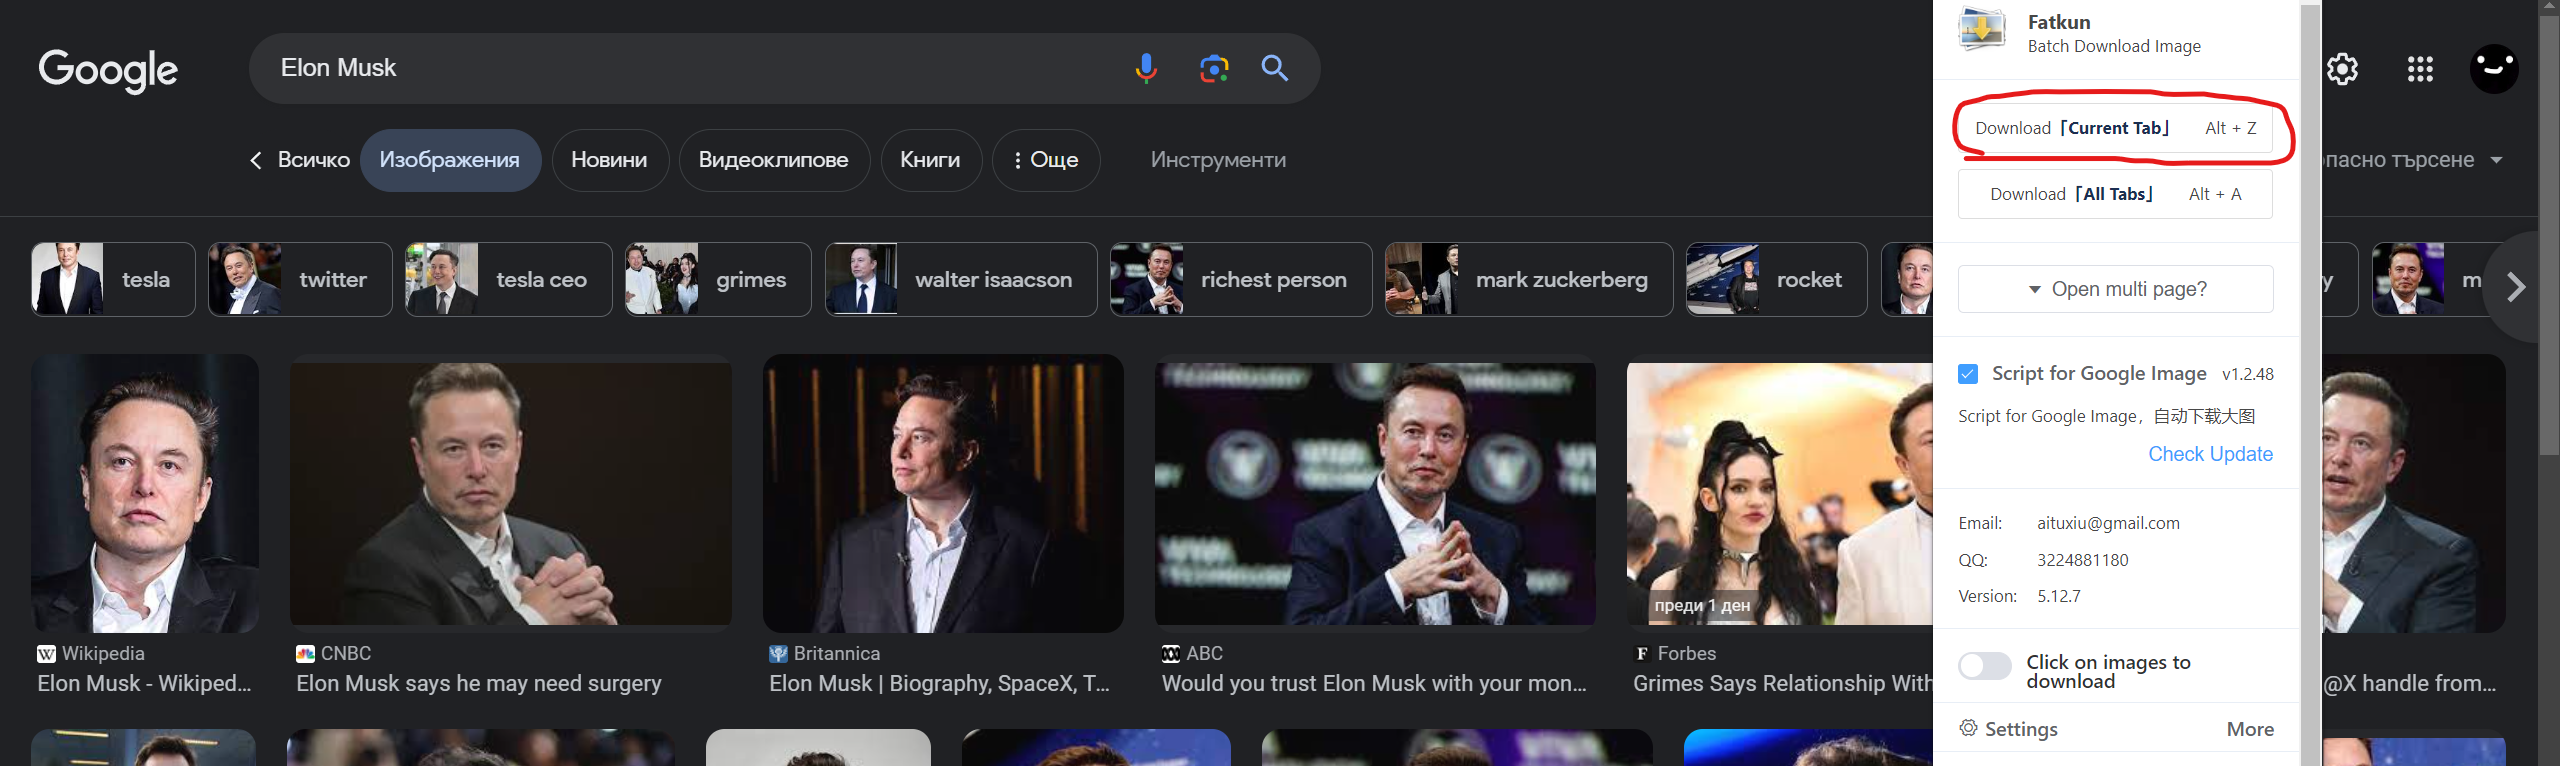

__Step 2__
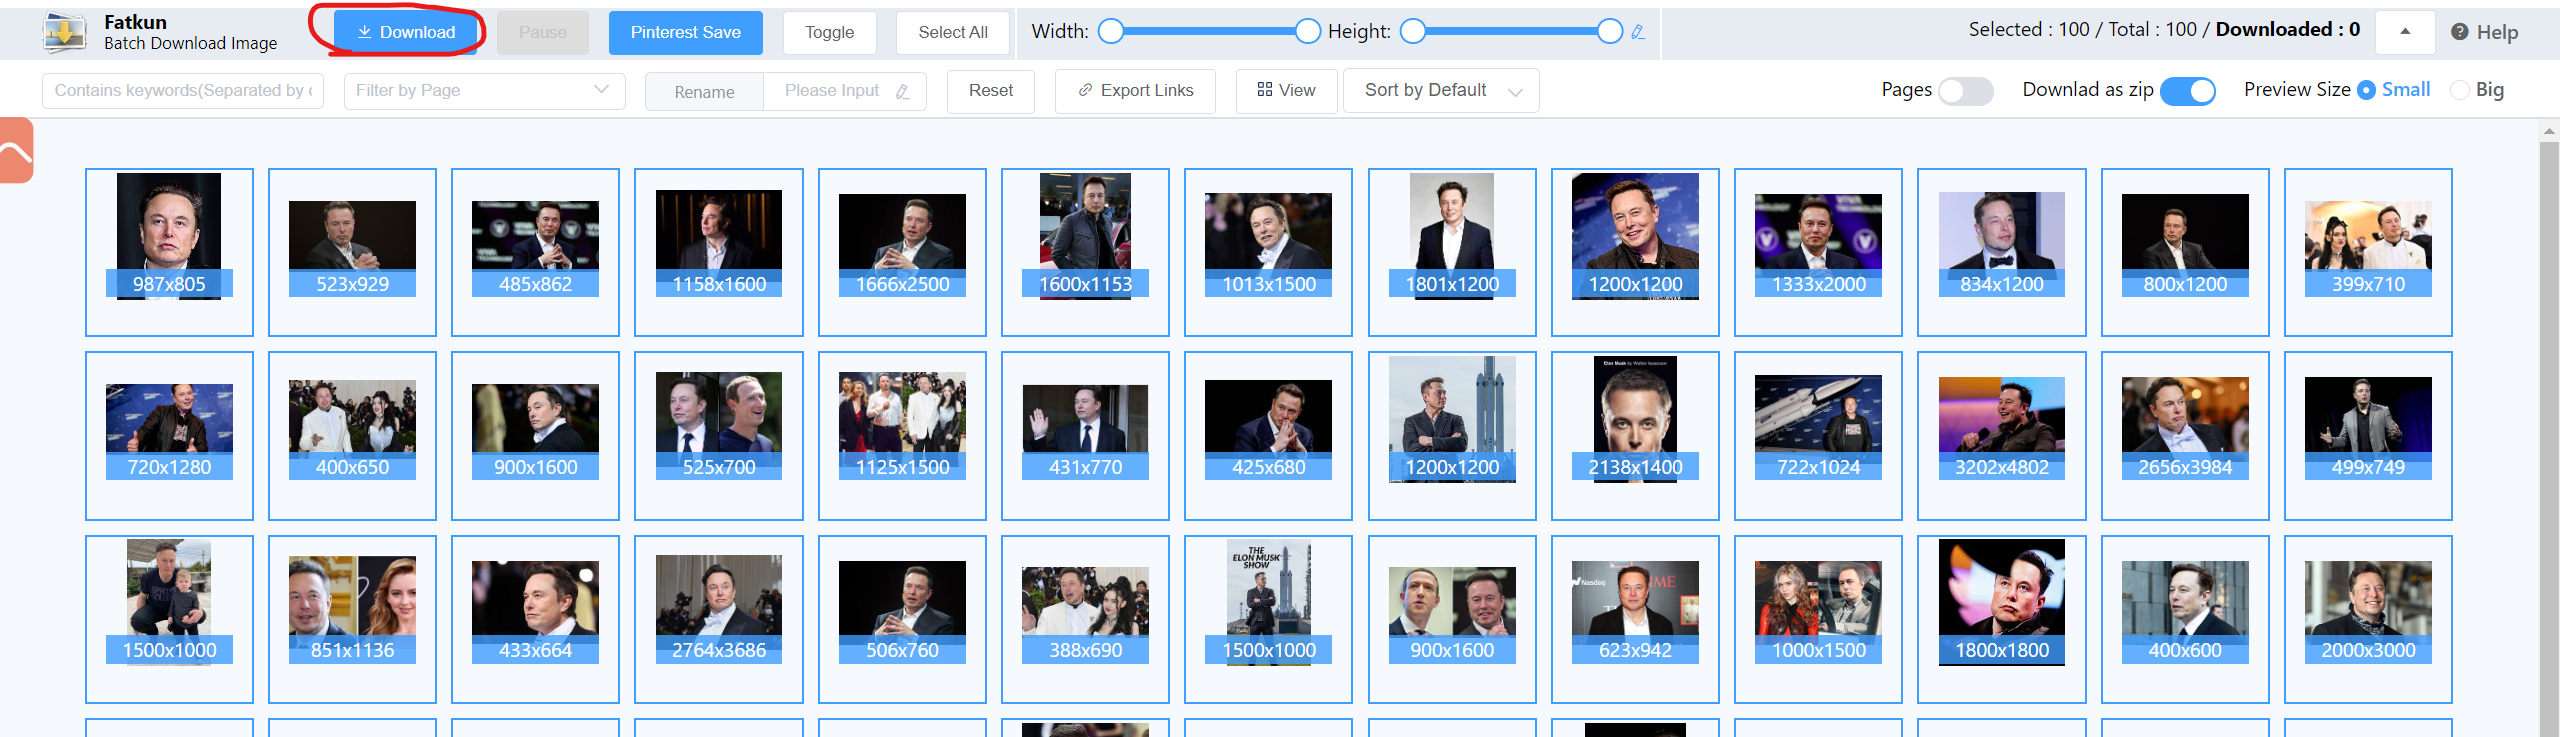

## 2. Cleaning the Data

Our next step is to clean the images downloaded from Google so they can be effectively used to train our classifier. Since faces are the most common way we identify people in photos, we'll use OpenCV and a technique called Haar cascades to determine if each image clearly shows a face and two eyes. If it does, we'll keep the image; otherwise, we'll discard it. While much of the data cleaning will be done using Python code, some manual cleaning will also be necessary.

As we discussed earlier, we will utilize OpenCV and Haar cascades to clean up the images. To demonstrate how this works, I'll use an image of Andrew Tate. Initially, we will read the image using cv2 and then display it using matplotlib.

In [3]:
img = cv2.imread("test_image/andrew_tate.jpg")

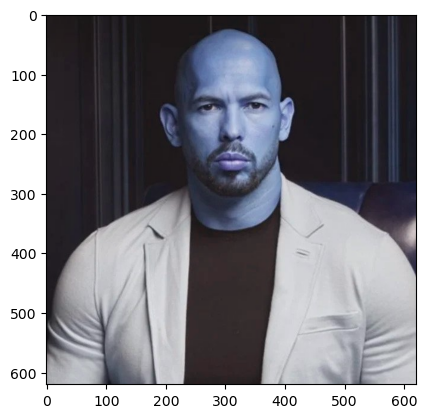

In [4]:
plt.imshow(img)

Have you noticed that Andrew appears blue like a Smurf? This is because OpenCV uses BGR color mode, while matplotlib uses RGB color mode, resulting in the switching of the blue and red color channels. To resolve this issue, simply provide matplotlib with an rgb image.

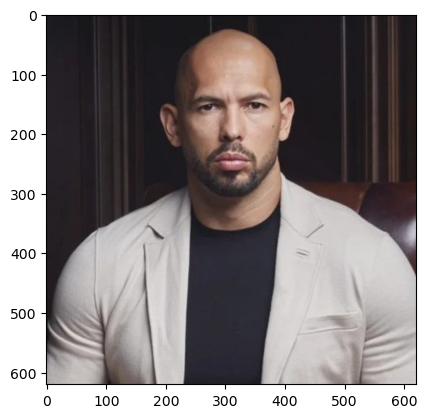

In [5]:
# converting BGR to RGB 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap = plt.cm.Spectral)

This "problem" is actually not a problem at all since we need to load our image in grayscale mode to use Haar-cascade Detection. However, it is a good idea to do so for visualization purposes. Let's proceed with loading our image in grayscale mode.

In [6]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

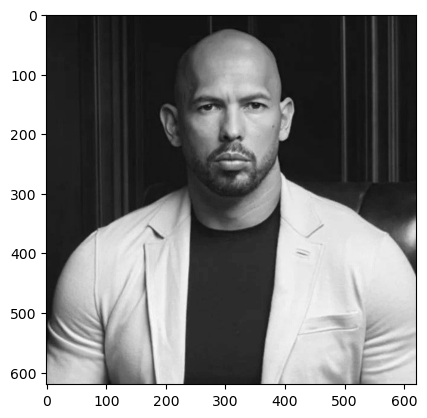

In [7]:
plt.imshow(gray_img, cmap='gray')

To detect Andrew's face and eyes we will need to load the required XML classifiers. Then we will give the detectMultiScale function our grey image and two more parameters:
* **scaleFactor** - Parameter specifying how much the image size is reduced at each image scale (1.3 works fine in this case). 
* **minNeighbors** - Parameter specifying how many neighbors each candidate rectangle should have to retain it. This parameter will affect the quality of the detected faces. Higher value results in less detections but with higher quality. 3~6 is a good value for it (In this case we are using 5).

In [8]:
face_cascade = cv2.CascadeClassifier('model/opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('model/opencv/haarcascades/haarcascade_eye.xml')

In this step, we will identify the faces present in the image. If any faces are detected, the function will return the positions of these faces as Rect(x,y,w,h) coordinates. With this information, we can create a region of interest (ROI) focused on the face and proceed with eye detection within this area.

In [9]:
# detects faces
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
faces

array([[210,  73, 204, 204]])

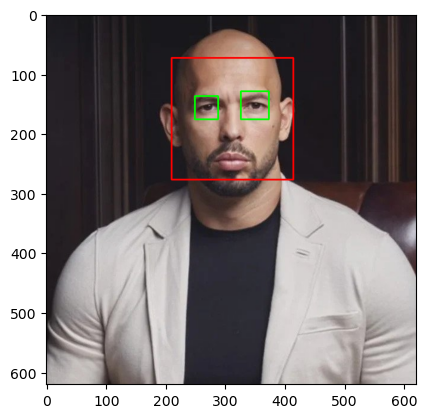

In [10]:
# the colors of the squares
red = (255,0,0)
green = (0,255,0)

for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w,y+h), red, 2)
    roi_gray = gray_img[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    # detects eyes
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh), green, 2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

Here's the outcome, but our focus is on Andrew's face in the image. Therefore, we'll only extract what's inside the red square.

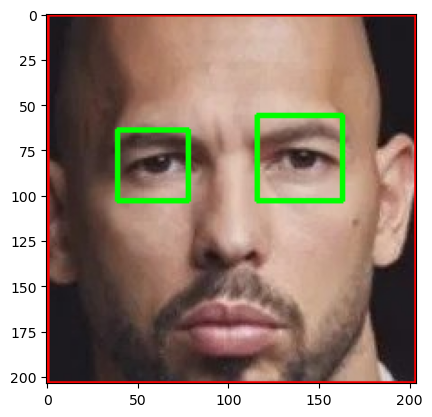

In [11]:
plt.imshow(roi_color, cmap='gray')

Beautiful! Our next step is to develop a function that can crop faces from all the images in our dataset. This function takes the image path as input and returns the cropped face as output.

In [12]:
def get_cropped_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

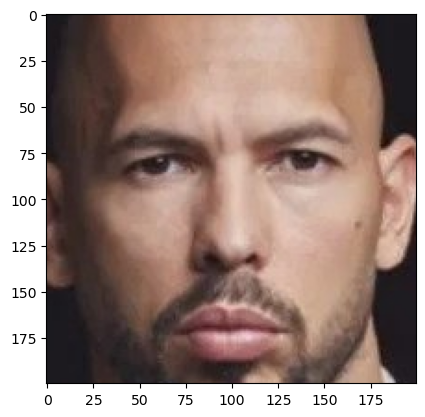

In [13]:
cropped_image = get_cropped_image("./test_image/andrew_tate.jpg")

# converting BGR to RGB once more
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_image, cmap = plt.cm.Spectral)

Now, we must create a folder to store all of the cropped images. Let's proceed with creating this folder.
To begin, we require the location of our dataset and the desired folder location for our cropped files.

In [16]:
path_to_data = "./dataset/"
path_to_cropped_data = "./dataset/cropped/"

We will add the paths of each celebrity's folder from the dataset to the img_dirs list.

In [18]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [19]:
img_dirs

['./dataset/andrew_tate',
 './dataset/cropped',
 './dataset/elon_musk',
 './dataset/leonardo_dicaprio',
 './dataset/lionel_messi',
 './dataset/rumen_radev']

Next, we will write a piece of code that creates the cropped folder.

In [17]:
import shutil
if os.path.exists(path_to_cropped_data):
     shutil.rmtree(path_to_cropped_data)
os.mkdir(path_to_cropped_data)

Our next task is to write a code that crops all the images in the dataset and saves them in the newly created "cropped" folder. The code has comments that provide an explanation for each step.

In [18]:

cropped_image_dirs = [] #------------------------------------------------------- it stores the cropped folder path of each of our celebrities
celebrity_file_names_dict = {} #------------------------------------------------ this dictionary will store the celebrity names as keys and lists of the cropped images as values. This will come in handy in the future.


for img_dir in img_dirs: #------------------------------------------------------ we go through each celebrity's folder.
    count = 1 #----------------------------------------------------------------- the count variable will be used for the names of the images
    celebrity_name = img_dir.split('/')[-1] #----------------------------------- splits the path and gets the last element - the name
    celebrity_file_names_dict[celebrity_name] = []
    
                                                                        
    for entry in os.scandir(img_dir): #----------------------------------------- we go through all the images in the folder of each celebrity
        roi_color = get_cropped_image(entry.path) 
        
        if roi_color is not None: #--------------------------------------------- if the face and eyes are clearly visible
            
            cropped_folder = path_to_cropped_data + celebrity_name #------------ the path of the current player's cropped folder 
            if not os.path.exists(cropped_folder): #---------------------------- if the cropped folder doesn't exist
                
                os.makedirs(cropped_folder) #----------------------------------- creates cropped folder
                cropped_image_dirs.append(cropped_folder) #--------------------- appends the path of the cropped folder
                print("Generating cropped images in folder: ", cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png" #---------- the cropped image name
            cropped_file_path = cropped_folder + "/" + cropped_file_name #------ the cropped image path
            
            cv2.imwrite(cropped_file_path, roi_color) #------------------------- stores the image in the current celebrity's folder
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)# appends the image path to the current celebrity in celebrity_file_names_dict 
            count += 1

Generating cropped images in folder:  ./dataset/cropped/andrew_tate
Generating cropped images in folder:  ./dataset/cropped/elon_musk
Generating cropped images in folder:  ./dataset/cropped/leonardo_dicaprio
Generating cropped images in folder:  ./dataset/cropped/lionel_messi
Generating cropped images in folder:  ./dataset/cropped/rumen_radev


Now we will write a function which implements a transformation using the Discrete Wavelet Transform (DWT) from the PyWavelets library. The function takes an input image (img) and performs a wavelet transformation on it, modifying certain coefficients to achieve a specific effect. So this is what the function does:

1. Data Conversion
    + __im_array = cv2.cvtColor(im_array, cv2.COLOR_RGB2GRAY)__: This line converts the image to grayscale using OpenCV's cvtColor function. Grayscale is often used for wavelet transformations since they are usually applied to single-channel (gray) images.
    
    + __im_array = np.float32(im_array)__: The grayscale image is converted to a float32 data type, which is a common data type for image processing operations.
    
    + __im_array /= 255__: The pixel values of the image are normalized to the range [0, 1] by dividing by 255. This is a common practice to bring pixel values within this range.
    
2. Compute Coefficients
    + __coeffs = pywt.wavedec2(im_array, mode, level=level)__: This line computes the 2D wavelet coefficients of the normalized grayscale image. The wavedec2 function performs the DWT on the image using the specified wavelet mode and decomposition level.
    
3. Process Coefficients
    + __coeffs_H = list(coeffs)__: The wavelet coefficients are converted into a list, presumably to modify them.
    
    + __coeffs_H[0] *= 0__: The approximation coefficients (low-pass filtered) at the coarsest level are zeroed out, effectively removing low-frequency components.
    
4. Reconstruction
    + __im_array_H = pywt.waverec2(coeffs_H, mode)__: The modified coefficients are used to reconstruct an image using the inverse DWT. This results in a modified version of the input image, with certain frequency components removed or altered.
    
5. Data Conversion and Output
    + __im_array_H *= 255__: The pixel values of the modified image are scaled back to the range [0, 255].
    
    + __im_array_H = np.uint8(im_array_H)__: The pixel values are converted back to the uint8 data type, which is the standard data type for images with pixel values in the range [0, 255].

In [57]:
def w2d(img, mode='haar', level=1):
    # Input
    im_array = img
    
    # Data Conversion
    im_array = cv2.cvtColor( im_array,cv2.COLOR_RGB2GRAY )
    im_array =  np.float32(im_array)  
    im_array /= 255
    
    # Compute Coefficients 
    coeffs = pywt.wavedec2(im_array, mode, level=level)

    # Process Coefficients
    coeffs_H = list(coeffs)  
    coeffs_H[0] *= 0  

    # Reconstruction
    im_array_H = pywt.waverec2(coeffs_H, mode)
    
    # Data Conversion and Output
    im_array_H *= 255
    im_array_H = np.uint8(im_array_H)

    return im_array_H

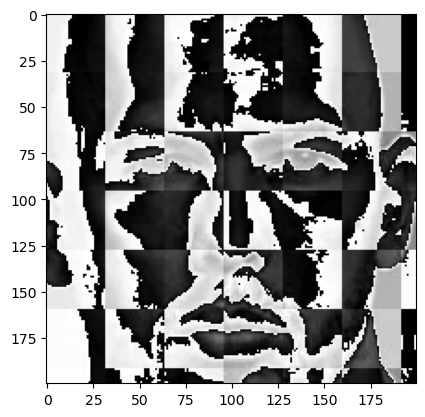

In [58]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

It is now time for us to put in some manual effort. This involves deleting the cropped images of individuals who do not belong to our group of 5 celebrities.

__Example 1__ 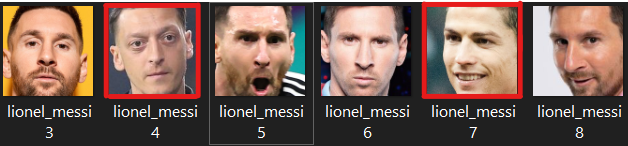

__Example 2__ 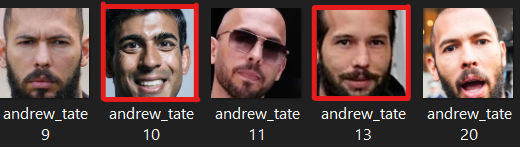

The images *lionel_messi4*, *lionel_messi7*, *andrew_tate10* and *andrew_tate13* have to be deleted.

# 3. Training the Model

## Preparation

Now we will perform a wavelet transformation on every cropped image. Then we will vertically stack the colorfull image and the transformed image like this:

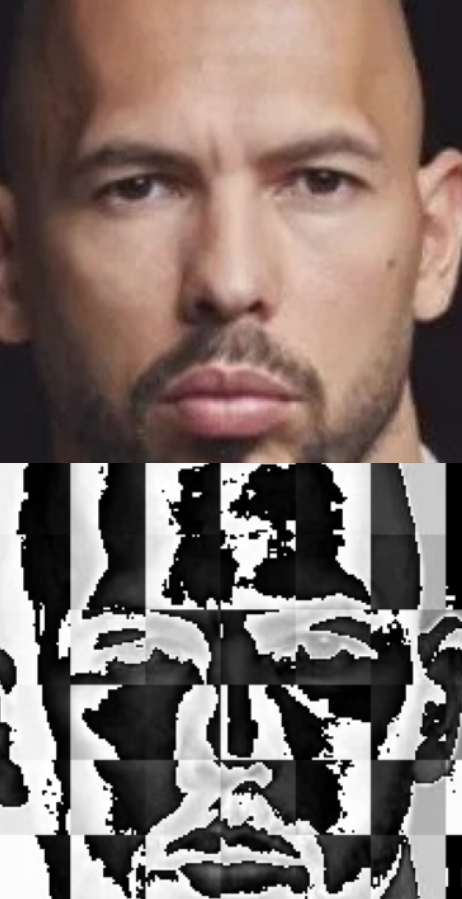

To ensure effective communication with the machine learning model, we will use numerical designations instead of the celebrities' actual names. This will facilitate smooth data processing and avoid confusion.

In [21]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'andrew_tate': 0,
 'elon_musk': 1,
 'leonardo_dicaprio': 2,
 'lionel_messi': 3,
 'rumen_radev': 4}

To prepare for model training, we'll iterate through the dictionary 'celebrity_file_names_dict' we created earlier. For each image, we'll apply the wavelet transformation using the 'w2d' function. We'll resize both the transformed and original images to ensure they're the same size. Using numpy, we'll stack the images vertically and add them to the 'X' list. We'll also add the corresponding celebrity names, which we assigned earlier, to the 'y' list. These lists will be used for the model's training.

+ __X__: This represents the feature data, often a two-dimensional array (or DataFrame) where each row corresponds to an instance and each column corresponds to a feature.

+ __y__: This represents the target labels or values corresponding to each instance in X.

In [22]:
X, y = [], []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [23]:
print(f'Total number of images: {len(X)}')

Total number of images: 759


In [24]:
print(f'Size of each image: {len(X[0])}')
X[0]

Size of each image: 4096


array([[ 84],
       [ 89],
       [113],
       ...,
       [  4],
       [250],
       [  3]], dtype=uint8)

We will convert the images from int to float point for the training.

In [25]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(759, 4096)

## Training

Let's try using SVM with rbf kernel tuned with heuristic finetuning

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

Now we will split the dataset into training and testing sets.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

0.8947368421052632

+ __train_test_split()__: This is a function provided by the scikit-learn library (sklearn.model_selection module) that splits the data into training and testing sets. It helps in creating subsets of your dataset for training and testing purposes, which is essential for evaluating the performance of machine learning models.

+ __random_state__: This parameter controls the randomness of the data splitting process. When you set random_state to a specific value, the data splitting process becomes reproducible, meaning that if you use the same value in the future, you will get the same train-test split. This is helpful for debugging and ensuring consistent results.

Now, let's explain how the code works:

+ __X_train__: This variable will hold the subset of feature data that will be used for training the machine learning model. It's a random portion of the original X data.

+ __X_test__: This variable will hold the subset of feature data that will be used for testing the trained machine learning model. This data is separate from the training data to evaluate how well the model generalizes to unseen examples.

+ __y_train__: This variable will hold the corresponding target labels/values for the training instances in X_train.

+ __y_test__: This variable will hold the corresponding target labels/values for the testing instances in X_test.

The __train_test_split()__ function takes the __X__ and __y__ data, along with the optional __random_state__, and divides the dataset into training and testing sets according to a default ratio (often 75% training and 25% testing). This split helps you train a machine learning model on a portion of the data and then assess its performance on unseen data. This process is essential to avoid overfitting and evaluate how well your model generalizes to new, unseen examples.

We will use GridSearch to experiment with various models with different parameters. Our objective is to identify the most optimal model with finely tuned parameters.

In [31]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

Let's break down each section of the dictionary:

1. '__svm__':

    + '__model__': This specifies the machine learning model to use, which is Support Vector Machine (SVM) with a radial basis function ('rbf') kernel. __The gamma parameter__ is set to '__auto__', and __probability__ is set to __True__, allowing the model to output class probabilities.
    + '__params__': This nested dictionary contains hyperparameter values to be considered during hyperparameter tuning for the SVM model. In this case, the '__C__' parameter of the SVC is to be tuned over the values __[1, 10, 100, 1000]__, and the '__kernel__' parameter is to be tuned over the values '__rbf__' and '__linear__'.

2. '__random_forest__':

    + '__model__': This specifies the machine learning model to use, which is a Random Forest Classifier.
    + '__params__': This nested dictionary contains hyperparameter values to be considered during hyperparameter tuning for the Random Forest model. Specifically, the '__n_estimators__' parameter (number of trees in the forest) is to be tuned over the values __[1, 5, 10]__.

3. '__logistic_regression__':

    + '__model__': This specifies the machine learning model to use, which is Logistic Regression. The '__solver__' parameter is set to '__liblinear__', and '__multi_class__' is set to '__auto__'.
    + '__params__': This nested dictionary contains hyperparameter values to be considered during hyperparameter tuning for the Logistic Regression model. The '__C__' parameter is to be tuned over the values [1, 5, 10].

Now we will try the models with the assigned parameters.

In [32]:
scores = []
best_estimators = {}

for algo, mp in model_params.items(): # iterates through the models
    pipe = make_pipeline(StandardScaler(), mp['model']) # scales the data
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

model  best_score  \
0                  svm    0.875252   
1        random_forest    0.615153   
2  logistic_regression    0.884071   

                                    best_params  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 10}  
2                 {'logisticregression__C': 10}

Based on the results, it appears that logistic_regression has the highest score, followed closely by svm. However, random_forest has the lowest score.
Moving forward, we will test with the X_test and y_test data sets.

In [33]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, solver='liblinear'))])}

In [34]:
best_estimators['svm'].score(X_test, y_test)

0.9315789473684211

In [35]:
best_estimators['random_forest'].score(X_test, y_test)

0.6578947368421053

In [36]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.9105263157894737

It seems that the rankings have shifted, as svm and logistic_regression have swapped positions. Unfortunately, random_forest is still at the bottom with the lowest score. Therefore, I have decided to utilize the svm model and save it in the best_clf variable.

In [37]:
best_clf = best_estimators['svm']

Let's utilize a confusion matrix to evaluate the model's performance with each individual celebrity. For improved visualization, we will use seaborn.

In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[25,  0,  3,  0,  0],
       [ 1, 32,  3,  0,  0],
       [ 2,  0, 62,  0,  0],
       [ 2,  0,  0, 31,  0],
       [ 0,  0,  2,  0, 27]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

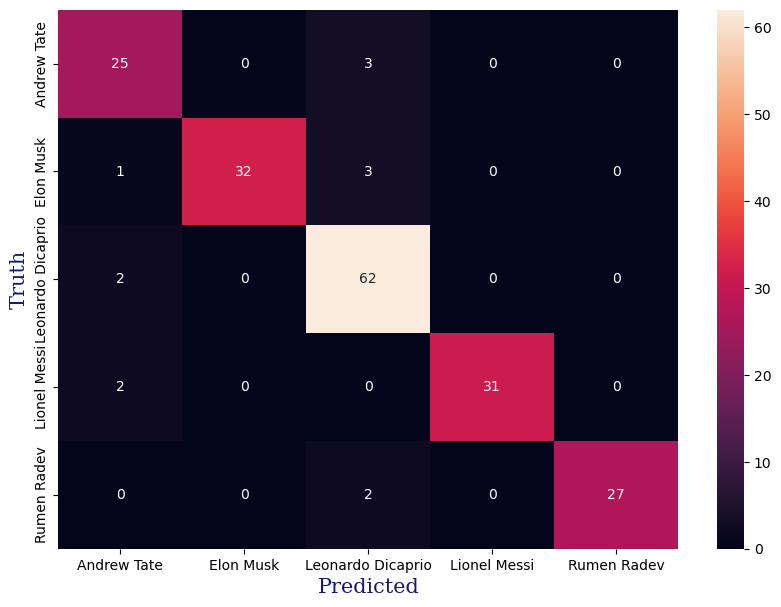

In [50]:
import seaborn as sn
labels = ['Andrew Tate', 'Elon Musk', 'Leonardo Dicaprio', 'Lionel Messi', 'Rumen Radev']
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
font = {'family':'serif','color':'midnightblue','size':15}
plt.xlabel('Predicted', fontdict = font)
plt.ylabel('Truth', fontdict = font)

The colorful diagonal indicates the number of samples that our model predicted accurately.

## Saving the trained model and the class dictionary

### 1. Model

In [40]:
class_dict

{'andrew_tate': 0,
 'elon_musk': 1,
 'leonardo_dicaprio': 2,
 'lionel_messi': 3,
 'rumen_radev': 4}

We will now save the trained model and class dictionary, allowing us to utilize them for our website.

In [41]:
import joblib
# Save the model as a pickle in a file
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### 2. Class dictionary

In [42]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))